<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/big_input/Usar_telescopios_disp_para_evento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para intentar mejorar todo lo de la predicción un poco vamos a hacer que la predicción tenga todos los telescopios ara un evento y meta mas o menos telescopios en el model segun toque para la prediccion, no se muy bien como hacer.

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import re
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#VAMOS A HACER UNA FUNCION QUE NOS INDICA LOS TELESCOPIOS QUE PARTICIPAN EN UN EVENTO
#esto es independiente entre elementos, da iwa, cada elemento tiene sus evento.
#dada una run, tambien son independietes los eventos, entonces, tu me dices :
#elemento, run y id del evento y yo te digo los telescopios involucrados

In [ ]:
def list_txts(base_txt_dir,elemento,run):
    regex=f"{base_txt_dir}/*/{elemento}_tel_*_run_{str(run).zfill(2)}.txt"
    return sorted(glob.glob(regex),key=lambda x: int(re.findall("tel_([0-9]*)_",x)[0]))
 
#a=list_txts("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",1)

In [ ]:
#una funcion que dado elemento y run nos diga los ids de todos los eventos ocurridos
def id_events(base_txt_dir,elemento,run):
    #buscamos todos los txt todos los numeros de eventos y luego los contamos solo una vez
    eventos=np.array([])
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        eventos=np.concatenate((eventos,extract_info_txt(j,cols=0)))
 
    return np.asarray(sorted(np.unique(eventos)))
 
#id_events("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",2)

In [ ]:
def eventos_y_telescopios(base_txt_dir,elemento,run):
    #esta funcion nos crea un disccionario con el numero de evento y con los telescopios que forman parte
    #cuando abrimos una txt vemos que eventos hay dentro y añadimos al total los telescopios segun toque
    event_tels={}
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        tel_aux=int(re.findall("tel_([0-9]*)_",j)[0])
        events_aux=extract_info_txt(j,cols=0)
        for k in events_aux:
            if k not in event_tels.keys():
                event_tels[k]=[tel_aux]
            else:
                event_tels[k].append(tel_aux)
    return event_tels

In [ ]:
def eventos_y_energia(base_txt_dir,elemento,run):
    #esta funcion nos crea un disccionario con el numero de evento y con los telescopios que forman parte
    #cuando abrimos una txt vemos que eventos hay dentro y añadimos al total los telescopios segun toque
    event_tels={}
    #buscamos para todos los telescopios
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        events_aux=extract_info_txt(j,cols=[0,2])
        for p,k in enumerate(events_aux[0]):
            if k not in event_tels.keys():
                event_tels[k]=events_aux[1][p]
                
 
    return event_tels

In [ ]:
eventos_y_energia("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e772b96878da>", line 1, in <module>
    eventos_y_energia("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",2)
  File "<ipython-input-6-0ab7c65a2437>", line 10, in eventos_y_energia
    events_aux=extract_info_txt(j,cols=[0,2])
NameError: name 'extract_info_txt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lo

NameError: ignored

In [ ]:
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    cols_names=["event"
    ,"telescope"
    ,"energy"
    ,"core distance to telescope"
    ,"image size (amplitude) [p.e.]"
    ,"number of pixels in image"
    ,"width [deg.]"
    ,"length [deg.]"
    ,"distance [deg.]"
    ,"miss [deg.]"
    ,"alpha [deg.]"
    ,"orientation [deg.]"
    ,"direction [deg.]"
    ,"image c.o.g. x [deg.]"
    ,"image c.o.g. y [deg.]"
    ,"Xmax [g/cm^2]"
    ,"Hmax [m]"
    ,"Npe (true number of photo-electrons)"
    ,"(19-23): Hottest pixel amplitudes)"]
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")
 
    else:
        return np.array([float(j[cols]) for j in a]).astype("float")

In [ ]:
a=eventos_y_telescopios("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",2)
b=eventos_y_telescopios("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",3)

In [ ]:
for i in a.keys():
    if i in b.keys():
        print(a[i],b[i])

#vemos que han coincidido de run a run mucho ids de eventos, pero son idependientes entre runs y entre elementos tbn,
#lo vemos claro porque no comparten los mismo telescopios triggered.
#a ver algo raro paso, porque en algunos casos coincide mas de los esperado no? o que?, na me rallo

In [ ]:
#ahora lo que podemos hacer es seleccionar aquellos que tengan mismo numero de telescopios de un tipo 
#y usar eso para entrenar una red con una cantidad concreta de telescopios.
#Aquí estaríamos pecando de simplicidad, porque nos estaría dando igual la posicion de los telescopios, y la idea
#era que aprendieran algun tipo de estructura en los eventos... joder

# Input con multiples telescopios en una sola imagen

In [ ]:
b=eventos_y_telescopios("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21","electron",3)
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

In [ ]:
b

{500.0: [4, 5, 6, 11, 29, 30, 31, 32, 33, 34, 58, 59, 60, 61],
 800.0: [5, 6, 30, 31, 32, 58, 59, 60, 61],
 900.0: [4, 5, 6, 11, 32, 58, 59, 60, 61],
 1500.0: [58, 59, 60, 61],
 1800.0: [29, 31, 33, 58, 59, 60, 61],
 2100.0: [29, 33, 58, 59, 60, 61],
 2300.0: [34, 58, 59, 60, 61],
 2500.0: [4, 5, 6, 11, 29, 58, 59, 60, 61],
 2900.0: [4, 29, 33, 58, 60],
 3400.0: [5, 6, 30, 31, 32, 34, 58, 59, 60, 61],
 3500.0: [33, 34, 58, 59, 60, 61],
 4000.0: [34, 86],
 4400.0: [30, 34, 58, 59, 60, 61],
 4500.0: [59, 61],
 5300.0: [58, 60],
 5400.0: [58, 59, 60, 61],
 5500.0: [29, 33, 34, 58, 60, 85],
 5800.0: [30, 59, 61],
 5900.0: [58, 59, 60, 61],
 6600.0: [4, 6, 29, 31, 33, 58, 59, 60, 61],
 7300.0: [11, 29, 33, 34, 58, 59, 60, 61],
 7400.0: [30, 31, 32, 59, 61],
 7700.0: [29, 33, 58, 59, 60, 61],
 7800.0: [33, 58, 60],
 7900.0: [4, 5, 6, 11, 58, 59, 60, 61],
 8400.0: [29, 31, 32, 58, 59, 60, 61],
 8900.0: [4, 11, 58, 59, 60, 61],
 9300.0: [6, 30, 31, 32, 58, 59, 60, 61],
 9900.0: [29, 58, 60],
 

In [ ]:
#primero vamos a hacer que dados un id de evento y unos telescopios,
#se nos forma la imagen de input
def input_img(id_evento,tels,element,run,base_txt_dir,base_npy_dir):
    shape1=(55,93)
    list_tels_shape1=[4,5,6,11,58,59,60,61,85,86]
    shape2=(84,56)
    list_tels_shape2=[29,30,31,32,33,34]
    shape3=(56,56)
    list_tels_shape3=[101,102,103,104]
    aux_ids=eventos_y_telescopios(base_txt_dir,element,run)
    #primero vemos que esta ese evento
    if id_evento not in aux_ids.keys():
        print("Ese evento no esta registrado en esta run.")
        return None
    #ahora es cuando tenemos que hacer imagen final a base de los diferentes telescopios, 
    #primero lo vamos a hacer sencillo, uno detras de otro y dejamos ceros si sobra
    #tenemos que buscar los indices par aluego buscarlo en el npy de imagenes
 
 
    #primero de todo creamos el array inicial donde los vamos a ir metiendo
    alto=56
    #lo vamos a hacer 56 de alto y de largo tanto como convenga para que quepan todos
    intersec1=len(set(tels).intersection(list_tels_shape1))
    intersec2=len(set(tels).intersection(list_tels_shape2))
    intersec3=len(set(tels).intersection(list_tels_shape3))
    largo=93*intersec1+84*intersec2+56*intersec3
 
    final_array=np.zeros((alto,largo))
    last_point=0
    #vamos telescopio por telescopio
    for j,i in enumerate(tels):
 
        if i in list_tels_shape1:
            len_aux=93
            alt_aux=55
            transpose=False
 
        elif i in list_tels_shape2:
            len_aux=84
            alt_aux=56
            transpose=True
        elif i in list_tels_shape3:
            len_aux=56
            alt_aux=56
            transpose=False
 
 
        if i in aux_ids[id_evento]:
            #si está seguimos adelante cargando el evento
            #tenemos que cargar la lista y ver el indice para luego cargar el evento
            indices_aux=np.load(f"{base_npy_dir}/npy_{element}/id_eventos_npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}.npy")
            comprobar_shape_1=indices_aux.shape[0]
            num_indice=np.where(indices_aux==id_evento)[0][0]
            img_aux=np.load(f"{base_npy_dir}/npy_{element}/npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}_0.npy")
            comprobar_shape_2=img_aux.shape[0]
            if comprobar_shape_1 != comprobar_shape_2:
                print(f"Error con las dimensiones del array de indices y el de imagenes para {element}: run {run}, tel {i}.")
            img_aux=img_aux[num_indice]
            if transpose:
                img_aux=np.transpose(img_aux)
            final_array[:alt_aux,last_point:(last_point+len_aux)]=img_aux
        else:
            pass
        #ahora tenemos que ir componiendo la imagen final poniendo una detras de otra
        last_point=last_point+len_aux
    return final_array

In [ ]:
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
aux=input_img(232600,[4,30,59,60,101],"electron",3,txt_dir,npy_dir)
aux.shape

In [ ]:
#ahora tenemos que apañar esto a lo grande
#le decimos unos telescopios, un elemento y una run y que nos devuelva una listao array con muchas
#primero vamos a hacer que dados un id de evento y unos telescopios,
#se nos forma la imagen de input
def big_input_img(tels,element,run,base_txt_dir,base_npy_dir,return_energies=False):
    shape1=(55,93)
    list_tels_shape1=[4,5,6,11,58,59,60,61,85,86]
    shape2=(84,56)
    list_tels_shape2=[29,30,31,32,33,34]
    shape3=(56,56)
    list_tels_shape3=[101,102,103,104]
    aux_ids=eventos_y_telescopios(base_txt_dir,element,run)
 
    num_eventos=len(aux_ids)
    if return_energies:
        energias=eventos_y_energia(base_txt_dir,element,run)
        if len(energias)!= num_eventos:
            print("Algun error con la lengitud de las labels y los eventos etc.. yo que se...")
    #ahora es cuando tenemos que hacer imagen final a base de los diferentes telescopios, 
    #primero lo vamos a hacer sencillo, uno detras de otro y dejamos ceros si sobra
    #tenemos que buscar los indices par aluego buscarlo en el npy de imagenes
 
 
    #primero de todo creamos el array inicial donde los vamos a ir metiendo
    alto=56
    #lo vamos a hacer 56 de alto y de largo tanto como convenga para que quepan todos
    intersec1=len(set(tels).intersection(list_tels_shape1))
    intersec2=len(set(tels).intersection(list_tels_shape2))
    intersec3=len(set(tels).intersection(list_tels_shape3))
    largo=93*intersec1+84*intersec2+56*intersec3
 
    final_array=np.zeros((num_eventos,alto,largo))
    last_point=0
    #vamos telescopio por telescopio
    if return_energies:
        labels_energias=[]
    for j,i in enumerate(tels):
 
        if i in list_tels_shape1:
            len_aux=93
            alt_aux=55
            transpose=False
 
        elif i in list_tels_shape2:
            len_aux=84
            alt_aux=56
            transpose=True
        elif i in list_tels_shape3:
            len_aux=56
            alt_aux=56
            transpose=False
 
 
        #si está seguimos adelante cargando el evento
        #tenemos que cargar la lista y ver el indice para luego cargar el evento
        indices_aux=np.load(f"{base_npy_dir}/npy_{element}/id_eventos_npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}.npy")
        comprobar_shape_1=indices_aux.shape[0]
        img_aux=np.load(f"{base_npy_dir}/npy_{element}/npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}_0.npy")
        comprobar_shape_2=img_aux.shape[0]
        if comprobar_shape_1 != comprobar_shape_2:
            print(f"Error con las dimensiones del array de indices y el de imagenes para {element}: run {run}, tel {i}.")
        for k,id_evento in enumerate(aux_ids.keys()):
            if i in aux_ids[id_evento]:
                num_indice=np.where(indices_aux==id_evento)[0][0]
                img_aux_2=img_aux[num_indice]
                if transpose:
                    img_aux_2=np.transpose(img_aux_2)
                final_array[k,:alt_aux,last_point:(last_point+len_aux)]=img_aux_2
            else:
                pass
            
            if return_energies:
                if j==0:
                    try:
                        labels_energias.append(energias[id_evento])
                    except:
                        print("Algun error con las keys de los eventos y las de las energias, nu se...")
 
                #para el primer telescopio solo, no hace falta mas
 
        last_point=last_point+len_aux
    if return_energies:
        return final_array, labels_energias
    else:
        return final_array

In [ ]:
def shape_input(tels):
    shape1=(55,93)
    list_tels_shape1=[4,5,6,11,58,59,60,61,85,86]
    shape2=(84,56)
    list_tels_shape2=[29,30,31,32,33,34]
    shape3=(56,56)
    list_tels_shape3=[101,102,103,104]
    #primero de todo creamos el array inicial donde los vamos a ir metiendo
    alto=56
    #lo vamos a hacer 56 de alto y de largo tanto como convenga para que quepan todos
    intersec1=len(set(tels).intersection(list_tels_shape1))
    intersec2=len(set(tels).intersection(list_tels_shape2))
    intersec3=len(set(tels).intersection(list_tels_shape3))
    largo=93*intersec1+84*intersec2+56*intersec3
    return (alto,largo)

In [ ]:
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
aux=big_input_img([4,5,6,11,30,59,60,101],"electron",3,txt_dir,npy_dir)

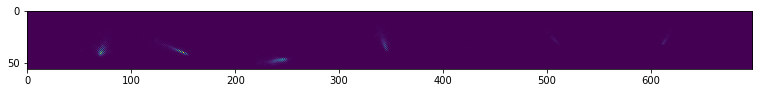

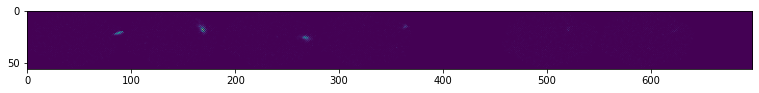

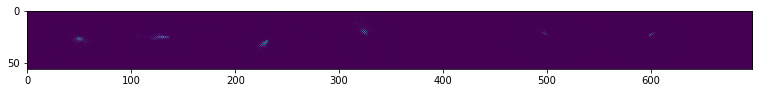

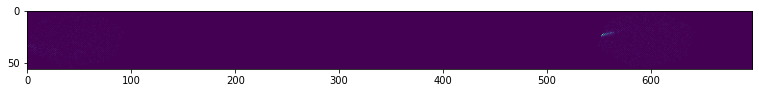

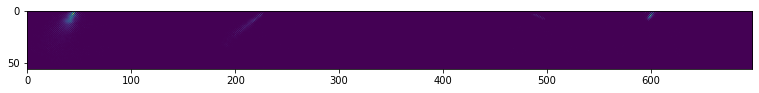

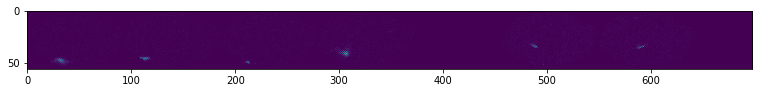

In [ ]:
for i in range(6):
    plt.figure(figsize=(13,13))
    plt.imshow(aux[i])

In [ ]:
#ahora hacemos para que esto lo haga para varias runs y todas juntas
def mult_runs_big_input_img(tels,element,runs,base_txt_dir,base_npy_dir,return_energies=False):
    if not return_energies:
        final=big_input_img(tels,element,runs[0],base_txt_dir,base_npy_dir)
        for i in runs[1:]:
            final=np.concatenate((final,big_input_img(tels,element,i,base_txt_dir,base_npy_dir)))
        return final
    else:
        final_array,final_labels=big_input_img(tels,element,runs[0],base_txt_dir,base_npy_dir,return_energies=return_energies)
        for i in runs[1:]:
            aux1,aux2=big_input_img(tels,element,i,base_txt_dir,base_npy_dir,return_energies=return_energies)
            final_array=np.concatenate((final_array,aux1))
            final_labels.extend(aux2)
        return final_array,final_labels

In [ ]:
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
aux=mult_runs_big_input_img([4,5,6,11,30,59,60,101],"electron",[1,2,3],txt_dir,npy_dir)
print(aux.shape)

(2122, 56, 698)


In [ ]:
#una funcion para crear la lista de list runs segun nos sea necesaria para indicar las runs a tomar de cada elemento
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)
 
 
            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)

In [ ]:
#final dataset function
#le pasamos los elementos y las runs que queremos de cada y obtenemos el dataset 
#con sus labels y todo. Las labels tambien las personalizamos
 
def data_set_longinput(tels,runs_list,base_txt_dir,base_npy_dir,labels=None,elements=None,test_size=0.2):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
        if labels is None:
            labels=[0,1,2,3,4,5,6]
    else:
        if labels is None:
            labels=np.arange(len(elements))
    if len(elements)!= len(labels):
        print("Error con la long de las labels y los elementos.")
        return None
    features_list=mult_runs_big_input_img(tels,elements[0],runs_list[0],base_txt_dir,base_npy_dir)
    labels_array=np.ones(features_list.shape[0])*labels[0]
    print(features_list.shape,labels_array.shape)
    for i,j in enumerate(elements[1:]):
        aux_element=mult_runs_big_input_img(tels,j,runs_list[i+1],base_txt_dir,base_npy_dir)
        features_list=np.concatenate((features_list,aux_element))
        labels_array=np.concatenate((labels_array,np.ones(aux_element.shape[0])*labels[i+1]))
        print(aux_element.shape[0],features_list.shape,labels_array.shape)
    features_list=features_list[...,np.newaxis]
    labels_array=tf.keras.utils.to_categorical(labels_array)
    x_train,x_test,y_train,y_test=train_test_split(features_list,labels_array,random_state=42,test_size=test_size)
    return x_train,x_test,y_train,y_test

In [ ]:
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs([2,2,2,2,2,2,2],random_select=False)
x_train,x_test,y_train,y_test=data_set_longinput([4,5,6,11,30,59,60,101],a,txt_dir,npy_dir,labels=None,elements=None)


(3998, 56, 698) (3998,)
1429 (5427, 56, 698) (5427,)
3714 (9141, 56, 698) (9141,)
2818 (11959, 56, 698) (11959,)
4537 (16496, 56, 698) (16496,)
1663 (18159, 56, 698) (18159,)
2277 (20436, 56, 698) (20436,)


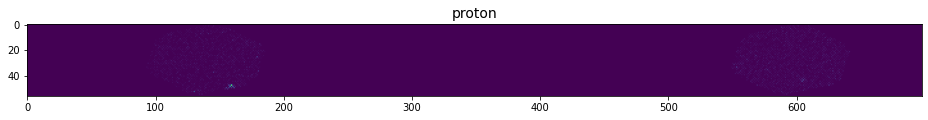

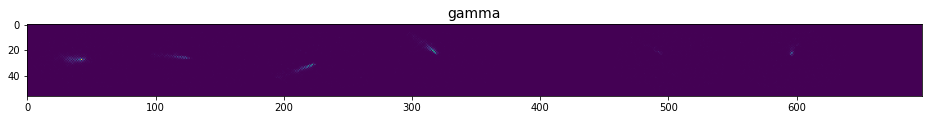

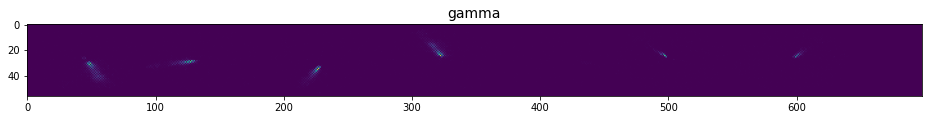

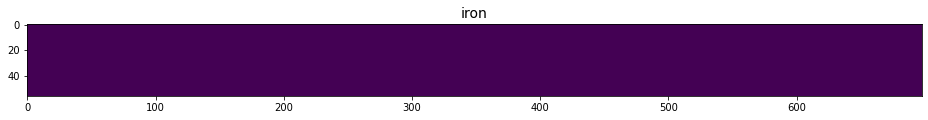

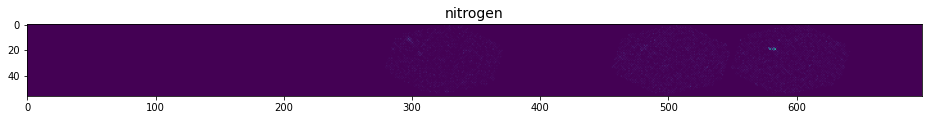

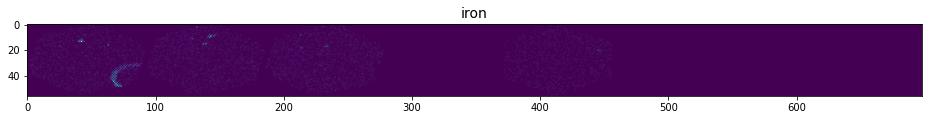

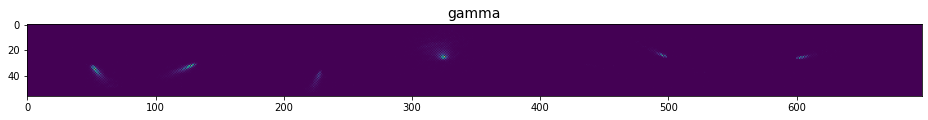

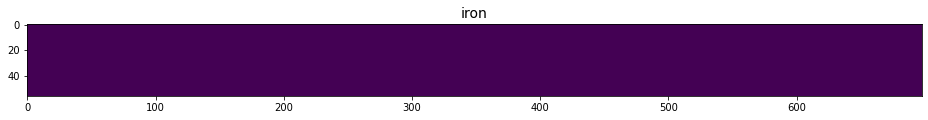

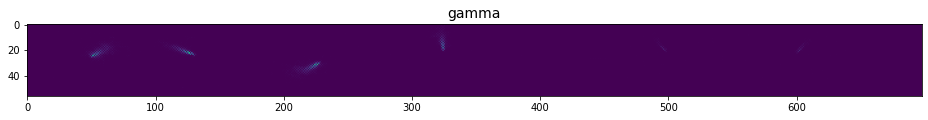

In [ ]:
#para ver como salen los inputs
elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

for i in range(14,23):
    plt.figure(figsize=(13,13))
    plt.imshow(x_train[i,:,:,0])
    plt.title(elements[np.argmax(y_train[i])],fontsize=14)
    plt.tight_layout()

In [ ]:
y_train.shape

(16348, 7)

In [ ]:
def print_conf_matrix(matrix,elements=None,sin_diag=True):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,13))
    sns.heatmap(matrix,annot=True)

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.title("True label en el eje Y, predicted en el eje X", fontsize=15)


def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1))
    print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag)



def display_max_errores(x_test,y_test,y_predicted,true_index=None,predict_index=None,sort_max=False):
    #primero tenemos que sacar aquellos que tengan maxima discrepancia entre lo predicho y lo real
    #sort max seria para sortearlas segun los maximo errores cometidos
    indices={}
    a=0
    if (true_index is None) or (predict_index is None):
        print("Dime que elemento quieres ver sus errores")
        return None

    if sort_max:
        #solo tenemos que meter primero a los que tengan mayor certeza de prediccion y asi ya nos sacara los erroneos
        indices_sort=np.argsort(y_predicted[:,predict_index])[::-1]
        #los mayores iran delante
        y_test=y_test[indices_sort]
        y_predicted=y_predicted[indices_sort]


    for i,j in enumerate(y_test):
        true_ind=np.argmax(j)
        predict_ind=np.argmax(y_predicted[i])
        if (true_ind!=predict_ind) and ((true_ind==true_index) and (predict_ind==predict_index)):
            indices[i]=y_predicted[i][predict_index], y_predicted[i][true_index]
    return indices

def plot_errors(x_test,y_test,y_predicho,true_index,predict_index,elementos=None,sort_max=False):

    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    a=display_max_errores(x_test,y_test,y_predicho,true_index=true_index,predict_index=predict_index,sort_max=sort_max)
    #vamos a ver algunos de los que se han confundido

    for i in range(0,8):
        fig=plt.figure(figsize=(10,8))
        indice=i #por orden natural
        indice_real= list(a)[indice]# el valor real en el x_test
        fig.suptitle(f"Se creyó que era {elementos[predict_index]} ({a[indice_real][0]*100:.2f}%), pero era {elementos[true_index]} ({a[indice_real][1]*100:.2f}%)",fontsize=15)
        for j in range(1,5):    
            plt.subplot(2,2,j)
            plt.imshow(x_test[j-1][indice_real][:,:,0])
            
        plt.tight_layout()

#Creamos el modelo para que procese todo

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 56, 624, 128)      1280      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 56, 624, 64)       73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 312, 64)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 312, 128)      73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 312, 64)       73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 156, 64)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 156, 64)      

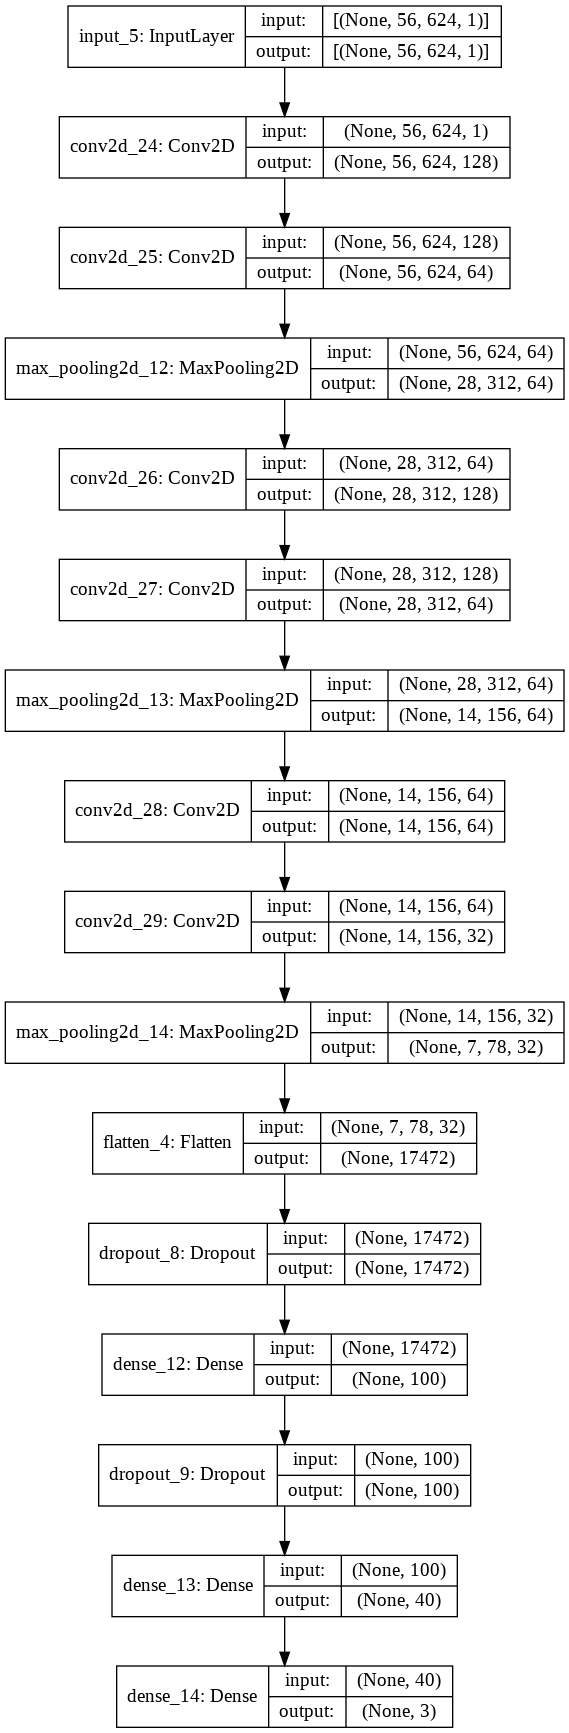

In [ ]:
#lo vamos a hacer con sequeantia fasil
tels=[4,5,6,11,29,30,31]
num_clases=3
model=tf.keras.Sequential([tf.keras.Input(shape=(*shape_input(tels),1))])
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
#model.add(tf.keras.layers.MaxPool2D())
#model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
#model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(100,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(40,activation="relu",kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(num_clases,activation="softmax"))
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)




In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
#cargamos los datos para entrenar 
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
tels=[4,5,6,11,29,30,31]
for i in range(10,20,2):
    a=create_lista_list_runs([1,2,2,2,2,2,2],init_events=np.ones(7)*i,random_select=False)
    #tels=[4,11,29,30,33,34,85,102,103,104]
    x_train,x_test,y_train,y_test=data_set_longinput(tels,a,txt_dir,npy_dir,labels=[0,1,2,2,2,2,2],elements=None)
    hist=model.fit(x_train,y_train,epochs=40,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])

(1999, 56, 624) (1999,)
1398 (3397, 56, 624) (3397,)
3746 (7143, 56, 624) (7143,)
2929 (10072, 56, 624) (10072,)
4740 (14812, 56, 624) (14812,)
1680 (16492, 56, 624) (16492,)
2265 (18757, 56, 624) (18757,)
Epoch 1/40
235/235 [==============================] - 53s 213ms/step - loss: 1.0496 - accuracy: 0.8835 - val_loss: 0.7213 - val_accuracy: 0.9272
Epoch 2/40
235/235 [==============================] - 47s 202ms/step - loss: 0.6817 - accuracy: 0.9320 - val_loss: 0.6172 - val_accuracy: 0.9304
Epoch 3/40
235/235 [==============================] - 47s 202ms/step - loss: 0.5860 - accuracy: 0.9393 - val_loss: 0.5498 - val_accuracy: 0.9334
Epoch 4/40
235/235 [==============================] - 47s 202ms/step - loss: 0.5194 - accuracy: 0.9383 - val_loss: 0.4994 - val_accuracy: 0.9331
Epoch 5/40
235/235 [==============================] - 47s 202ms/step - loss: 0.4672 - accuracy: 0.9399 - val_loss: 0.4588 - val_accuracy: 0.9344
Epoch 6/40
235/235 [==============================] - 48s 202ms/step 

In [ ]:
hist=model.fit(x_train,y_train,epochs=100,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/100
336/336 [==============================] - 161s 416ms/step - loss: 1.9805 - accuracy: 0.3424 - val_loss: 1.7126 - val_accuracy: 0.3298
Epoch 2/100
336/336 [==============================] - 133s 397ms/step - loss: 1.6025 - accuracy: 0.3817 - val_loss: 1.5525 - val_accuracy: 0.3790
Epoch 3/100
336/336 [==============================] - 133s 397ms/step - loss: 1.5366 - accuracy: 0.3930 - val_loss: 1.5218 - val_accuracy: 0.3877
Epoch 4/100
336/336 [==============================] - 133s 397ms/step - loss: 1.5077 - accuracy: 0.4045 - val_loss: 1.5057 - val_accuracy: 0.3950
Epoch 5/100
336/336 [==============================] - 133s 397ms/step - loss: 1.4995 - accuracy: 0.4040 - val_loss: 1.5032 - val_accuracy: 0.3903
Epoch 6/100
336/336 [==============================] - 133s 397ms/step - loss: 1.4778 - accuracy: 0.4142 - val_loss: 1.4862 - val_accuracy: 0.4040
Epoch 7/100
336/336 [==============================] - 133s 397ms/step - loss: 1.4671 - accuracy: 0.4161 - val_loss: 1

# Segunda cosa que intentar
No creo que sea muy óptimo hacer que el modelo procese una imagen asi grande porque mezcla los telescopios y no es plan, son imagenes mas o menos independientes.
A no ser que los pongamos en su posicion espacial... No se que más.
Lo mejor será que se procesen por separado. Que nuestro modelo tenga muchos inputs pero que sean 0 si no ha registrado nada.

In [ ]:
#creamos una funcion que recibe los eventos y los telescopios y pone la imagen si hay y sino 0 para todo

def multiple_imput_img(tels,element,run,base_txt_dir,base_npy_dir):
    shape1=(55,93)
    list_tels_shape1=[4,5,6,11,58,59,60,61,85,86]
    shape2=(84,56)
    list_tels_shape2=[29,30,31,32,33,34]
    shape3=(56,56)
    list_tels_shape3=[101,102,103,104]
    aux_ids=eventos_y_telescopios(base_txt_dir,element,run)
    num_eventos=len(aux_ids)
    #ahora es cuando tenemos que hacer imagen final a base de los diferentes telescopios, 
    #primero lo vamos a hacer sencillo, uno detras de otro y dejamos ceros si sobra
    #tenemos que buscar los indices par aluego buscarlo en el npy de imagenes


    #primero de todo creamos el array inicial donde los vamos a ir metiendo
    #lo vamos a hacer 56 de alto y de largo tanto como convenga para que quepan todos

    #vamos telescopio por telescopio
    array_all_tels=[]
    for j,i in enumerate(tels):

        if i in list_tels_shape1:
            len_aux=93
            alt_aux=55

        elif i in list_tels_shape2:
            len_aux=56
            alt_aux=84
        elif i in list_tels_shape3:
            len_aux=56
            alt_aux=56
        final_array=np.zeros((num_eventos,alt_aux,len_aux))

        #si está seguimos adelante cargando el evento
        #tenemos que cargar la lista y ver el indice para luego cargar el evento
        indices_aux=np.load(f"{base_npy_dir}/npy_{element}/id_eventos_npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}.npy")
        comprobar_shape_1=indices_aux.shape[0]
        img_aux=np.load(f"{base_npy_dir}/npy_{element}/npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}_0.npy")
        comprobar_shape_2=img_aux.shape[0]
        if comprobar_shape_1 != comprobar_shape_2:
            print(f"Error con las dimensiones del array de indices y el de imagenes para {element}: run {run}, tel {i}.")
        for k,id_evento in enumerate(aux_ids.keys()):
            if i in aux_ids[id_evento]:
                num_indice=np.where(indices_aux==id_evento)[0][0]
                img_aux_2=img_aux[num_indice]
                final_array[k]=img_aux_2
            else:
                pass
        
        array_all_tels.append(final_array)
        print(final_array.shape,len(array_all_tels))
    return array_all_tels

In [ ]:
def stack_runs_multiple_imput_img(tels,element,runs,base_txt_dir,base_npy_dir,get_element_shape=True,verbose=True):
    #con esta funcion apilamos los resultados de varios telescopios para diferentesruns
    #get_element_shape es para que nos diga cuanto hay de cada elemento, en el mismo orden que lo metimos nosotros
    if type(element)!=list:
        aux=multiple_imput_img(tels,element,runs[0],base_txt_dir,base_npy_dir)
        for i,j in enumerate(runs[1:]):
            aux=np.concatenate((aux,multiple_imput_img(tels,element,j,base_txt_dir,base_npy_dir)),axis=1)
        return aux
    elif type(element)==list:
        first= True
        shapes=[]
        for i,j in enumerate(element):
            shapes_aux=0
            if (type(runs[0])==list) or (type(runs[0])==np.ndarray):
                for k in runs[i]:
                    if first:
                        aux=multiple_imput_img(tels,j,k,base_txt_dir,base_npy_dir)
                        shapes_aux+=aux[0].shape[0]
                        first=False
                        if verbose:
                            print(j,k,len(aux),aux[0].shape)
                    else:
                        aux2=multiple_imput_img(tels,j,k,base_txt_dir,base_npy_dir)
                        shapes_aux+=aux2[0].shape[0]
                        aux=[np.concatenate((j,aux2[i]),axis=0) for i,j in enumerate(aux)]
                        if verbose:
                            print(j,k,len(aux2),aux2[0].shape)

            else:
                for k in runs:
                    if first:
                        aux=multiple_imput_img(tels,j,k,base_txt_dir,base_npy_dir)
                        shapes_aux+=aux[0].shape[0]
                        first=False
                        if verbose:
                            print(j,k,len(aux),aux[0].shape)
                    else:
                        aux2=multiple_imput_img(tels,j,k,base_txt_dir,base_npy_dir)
                        shapes_aux+=aux2[0].shape[0]
                        aux=[np.concatenate((j,aux2[i]),axis=0) for i,j in enumerate(aux)]
                        if verbose:
                            print(j,k,len(aux2),aux2[0].shape) 
            shapes.append(shapes_aux)
        if get_element_shape:
            return shapes, aux
        else:
            return aux

    else:
        print("Error con la lista de elementos")
        return  None

In [ ]:
def total_multiple_imput_img(tels,runs_list,base_txt_dir,base_npy_dir,elements=None,labels=None,test_size=0.2):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
        if labels is None:
            labels=[0,1,2,3,4,5,6]
    else:
        if labels is None:
            labels=np.arange(len(elements))
    if len(elements)!= len(labels):
        print("Error con la long de las labels y los elementos.")
        return None
    
    shapes,features_list=stack_runs_multiple_imput_img(tels,elements,runs_list,base_txt_dir,base_npy_dir,get_element_shape=True)
    labels_array=np.ones(shapes[0])*labels[0]
    for j,i in enumerate(shapes[1:]):
        labels_array=np.concatenate((labels_array,np.ones(i)*labels[j+1]))

    features_list=[i[...,np.newaxis] for i in features_list]
    labels_array=tf.keras.utils.to_categorical(labels_array)
    y_train,y_test=train_test_split(labels_array,random_state=42,test_size=test_size)
    x_train_list=[]
    x_test_list=[]
    for i,j in enumerate(tels):
        x_train,x_test=train_test_split(features_list[i],random_state=42,test_size=test_size)
        x_train_list.append(x_train)
        x_test_list.append(x_test)
    return x_train_list,x_test_list,y_train,y_test

In [ ]:
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
b=multiple_imput_img([4,5,6,11],"electron",2,txt_dir,npy_dir)

In [ ]:
c,d=stack_runs_multiple_imput_img([4,5,6,11],["electron","gamma"],[1,2],txt_dir,npy_dir,get_element_shape=True)

In [ ]:
x_train2,x_test,y_train,y_test=total_multiple_imput_img([4],[[1,2],[1,2]],txt_dir,npy_dir,["electron","gamma"])

1
(742, 55, 93) 1
electron 1 (1, 742, 55, 93)
2
(687, 55, 93) 1
electron 2 (1, 687, 55, 93)
1
(1999, 55, 93) 1
gamma 1 (1, 1999, 55, 93)
2
(1999, 55, 93) 1
gamma 2 (1, 1999, 55, 93)


#Nuevo modelo con muchos inputs procesados independent


In [ ]:
def model_multi_tel(len_inputs=None,input_shapes=[(55,93,1)],classes=7,learning_rate=1e-5,pre_proces_model=None,filtros=None,last_dense=None,autoencoder=None,common_pre=True):
    
    if (len_inputs==None) and (len(input_shapes)==1):
        print("Error, dime una shape y varios len_inputs, o dame muchas shapes y yo infiero las len_input, pero no me des solo una shape")
    elif len_inputs is None:
        len_inputs=len(input_shapes)

    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))

    if pre_proces_model:
        for i in range(len_inputs):
            outputs[i]=pre_proces_model(first_model=autoencoder)(inputs[i])
    else:
        if filtros is None:
            filtros=[[64,128],[128,254,64],[32]]
        #si no le metemos un modelo pues habra que meter aqui chicha porque sino se queda esto muy vacio
        if common_pre:
            pre_model=model_1_tel(input_shapes[0],filtros=filtros,first_part=True,first_model=autoencoder)
            outputs[0]=pre_model(inputs[0])
            for i in range(1,len_inputs):
                if input_shapes[i]!=input_shapes[i-1]:
                #esto esta suponiendo que ponemos juntos los que tienen igual shape
                    pre_model=model_1_tel(input_shapes[i],filtros=filtros,first_part=True,first_model=autoencoder) 
                outputs[i]=pre_model(inputs[i])

        else:
            for i in range(len_inputs):
                #SI QUEREMOS PONER AUTOENCODER TENEMOS QUE VER LA FOTMA DE COPIARLO
                pre_model=model_1_tel(input_shape=input_shapes[i],filtros=filtros,first_part=True)
                outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[165,35]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu",kernel_regularizer="l2")(x)
    end_layer=tf.keras.layers.Dense(classes,activation="softmax")(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


In [ ]:
def model_1_tel(input_shape=(55,93,1),filtros=None,batch_init=True,last_layers=None,avg_pooling=False,classes=7,learning_rate=1e-5,first_model=None,first_part=False):
    if filtros is None:
        filtros=[[64,32],[128,64,64],[32,16]]
    if last_layers is None:
        last_layer=[35,20]
    #lo vamos a hacer super customizable para probar esa vaina de entrenar muchos hiperparametros
    #estructura lo que nos mete son el numero de filtros conv y maxpool
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    if first_model:
        first_model.trainable=False
        model.add(first_model)
    if batch_init:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
    for i,j in enumerate(filtros):
        #aqui se alterna entre conv y maxpool(1) o average pool(-1)
        for k in j:
            model.add(tf.keras.layers.Conv2D(k,3,activation="relu"))
        if avg_pooling:
            model.add(tf.keras.layers.AveragePooling2D((2,2)))
        else:
            model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    if first_part:
        return model
    for j,i in enumerate(last_layers):
        model.add(tf.keras.layers.Dense(i,activation="relu"))
    model.add(tf.keras.layers.Dense(classes,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 84, 56, 1)]  0                                            
______________________________________________________________________________________________

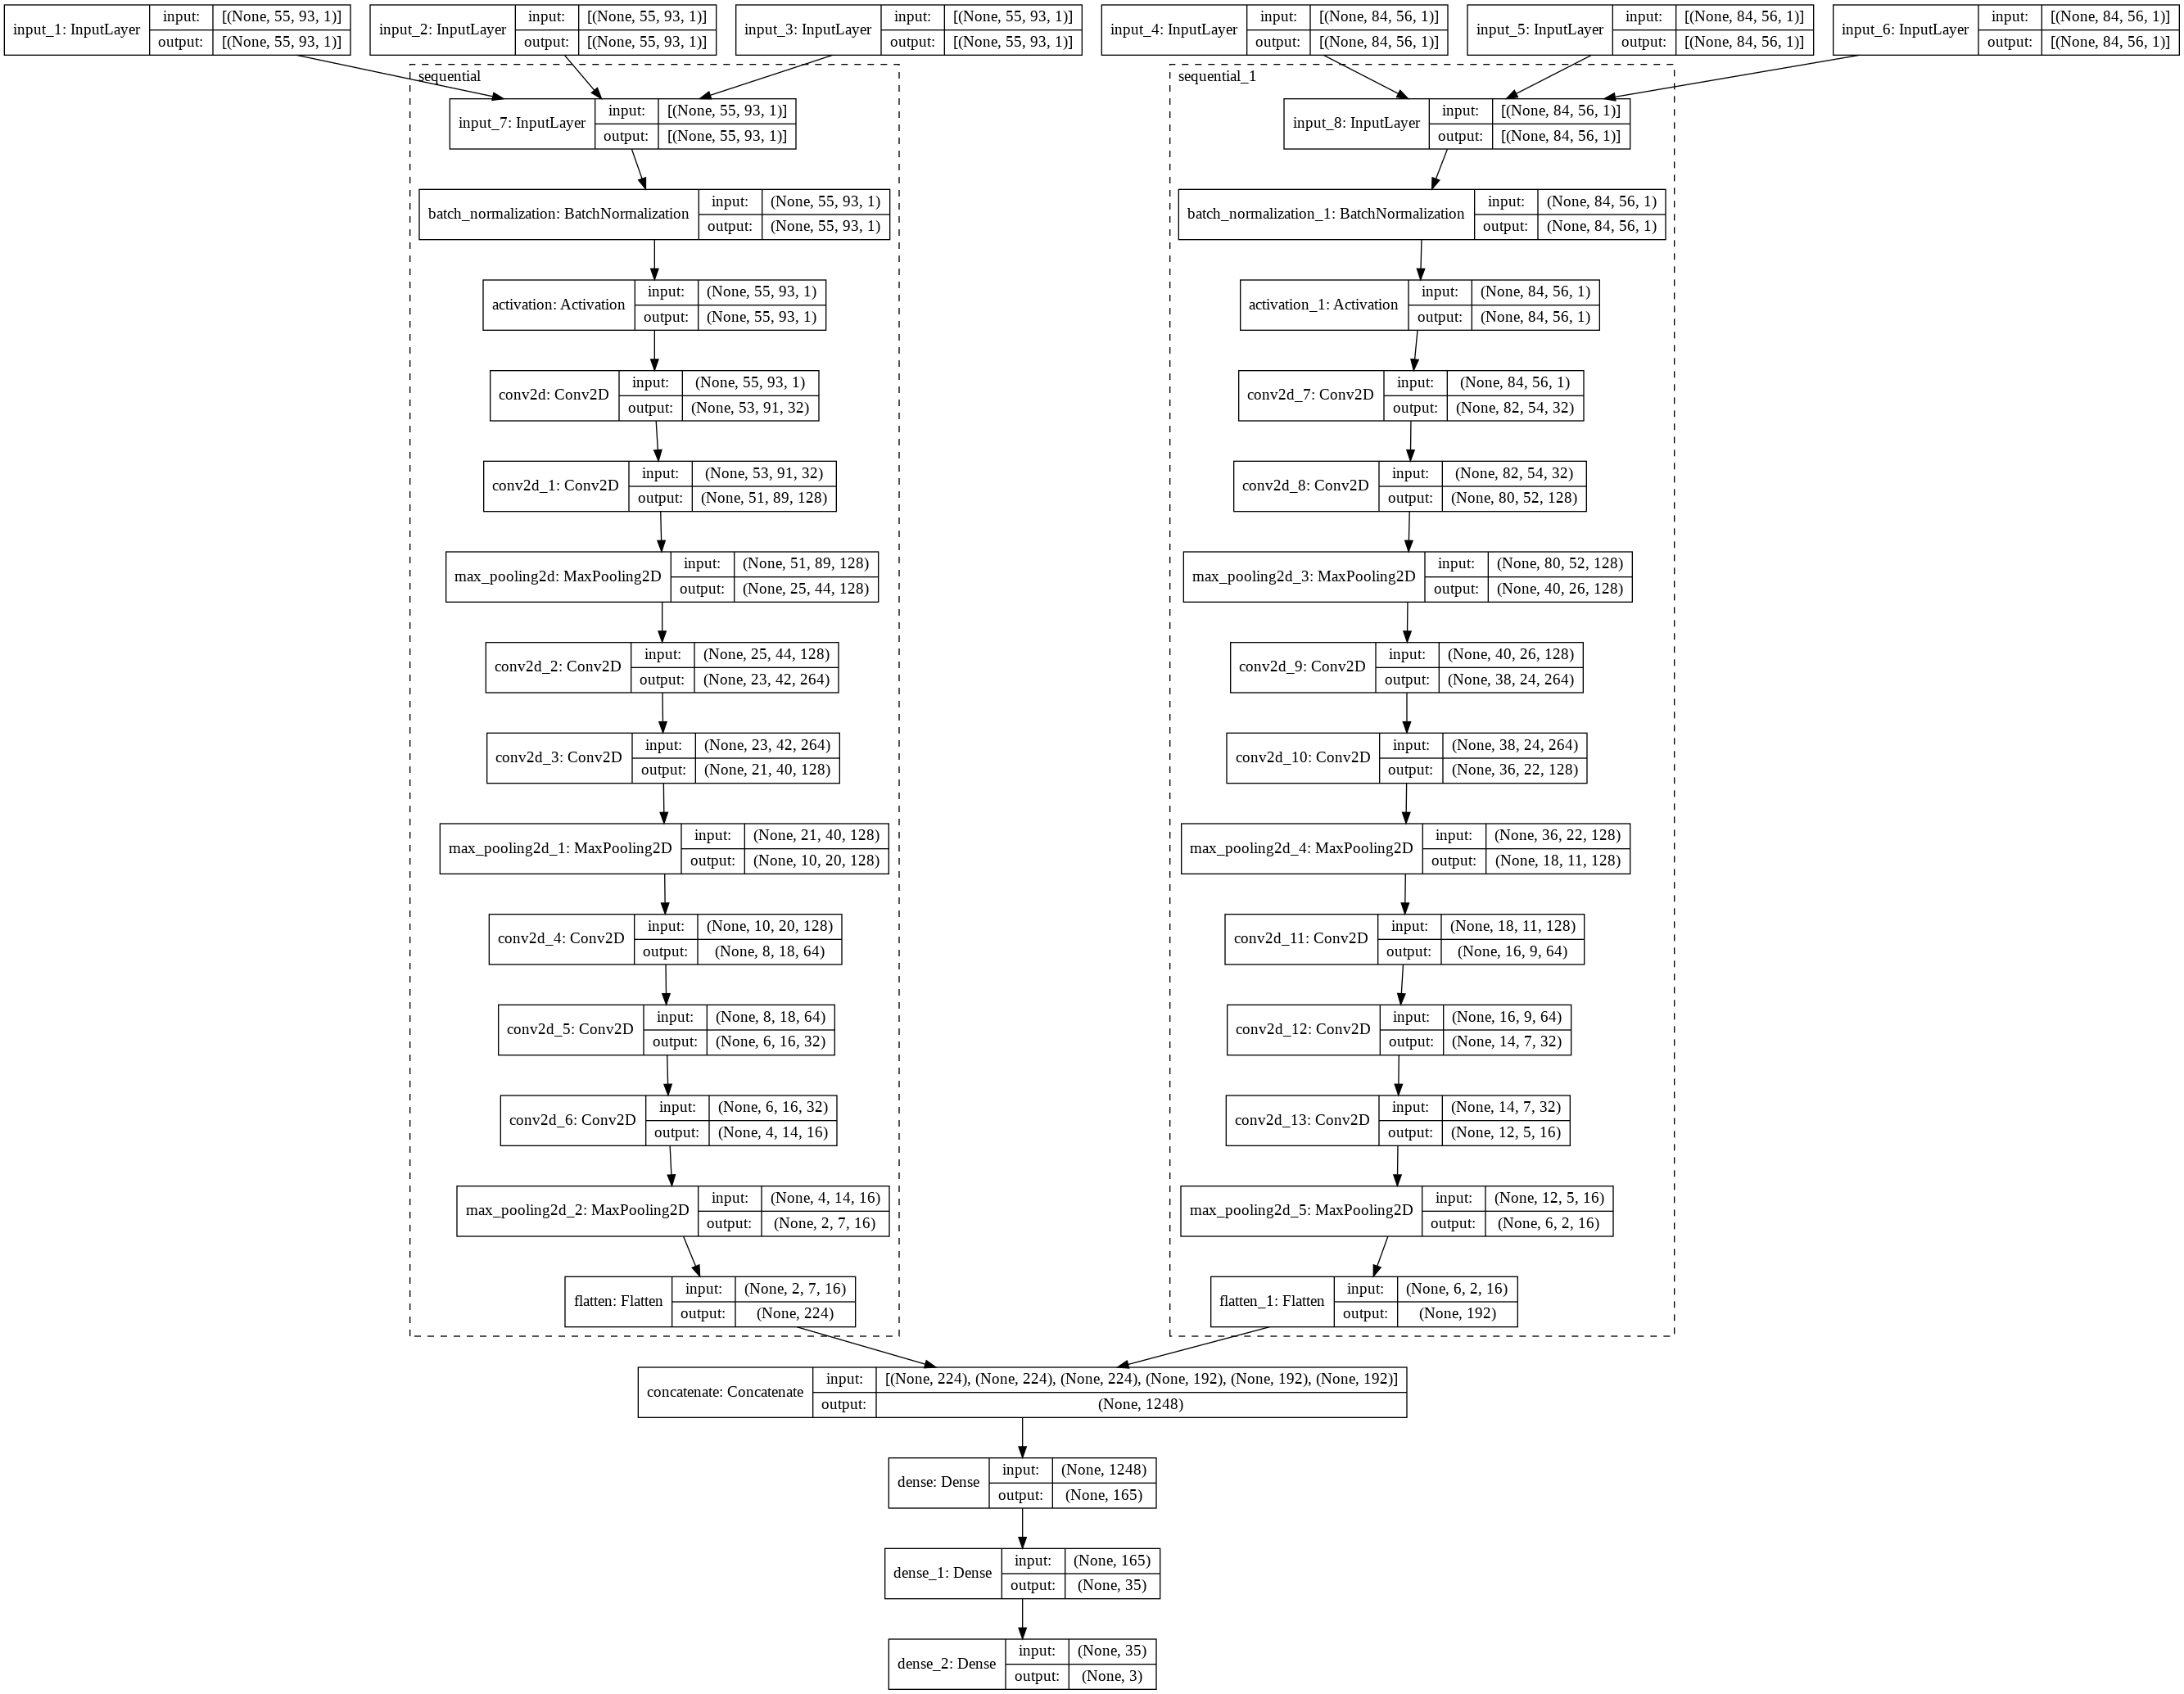

In [ ]:
#modelo_input=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/autoencoder_ground_truth_2_largetrain_out5292.h5")
tels=[4,5,6,29,31,33]
model=model_multi_tel(input_shapes=[(55,93,1),(55,93,1),(55,93,1),(84,56,1),(84,56,1),(84,56,1)],classes=3,learning_rate=1e-4,
                  pre_proces_model=None,last_dense=None,filtros=[[32,128],[264,128],[64,32,16]],common_pre=True)
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)

In [ ]:
#cargamos datos
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs([1,5,5,5,5,5,5],init_events=np.ones(7)*13,random_select=False)
x_train,x_test,y_train,y_test=total_multiple_imput_img([4,5,6,29,31,33],a,txt_dir,npy_dir,labels=[0,1,2,2,2,2,2])

(1999, 55, 93) 1
(1999, 55, 93) 2
(1999, 55, 93) 3
(1999, 84, 56) 4
(1999, 84, 56) 5
(1999, 84, 56) 6
gamma 13 6 (1999, 55, 93)
(687, 55, 93) 1
(687, 55, 93) 2
(687, 55, 93) 3
(687, 84, 56) 4
(687, 84, 56) 5
(687, 84, 56) 6
electron 13 6 (687, 55, 93)
(680, 55, 93) 1
(680, 55, 93) 2
(680, 55, 93) 3
(680, 84, 56) 4
(680, 84, 56) 5
(680, 84, 56) 6
electron 14 6 (680, 55, 93)
(733, 55, 93) 1
(733, 55, 93) 2
(733, 55, 93) 3
(733, 84, 56) 4
(733, 84, 56) 5
(733, 84, 56) 6
electron 15 6 (733, 55, 93)
(653, 55, 93) 1
(653, 55, 93) 2
(653, 55, 93) 3
(653, 84, 56) 4
(653, 84, 56) 5
(653, 84, 56) 6
electron 16 6 (653, 55, 93)
(663, 55, 93) 1
(663, 55, 93) 2
(663, 55, 93) 3
(663, 84, 56) 4
(663, 84, 56) 5
(663, 84, 56) 6
electron 17 6 (663, 55, 93)
(1893, 55, 93) 1
(1893, 55, 93) 2
(1893, 55, 93) 3
(1893, 84, 56) 4
(1893, 84, 56) 5
(1893, 84, 56) 6
proton 13 6 (1893, 55, 93)
(1916, 55, 93) 1
(1916, 55, 93) 2
(1916, 55, 93) 3
(1916, 84, 56) 4
(1916, 84, 56) 5
(1916, 84, 56) 6
proton 14 6 (1916, 55

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
hist=model.fit(x_train,y_train,epochs=100,batch_size=32,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/100
1092/1092 [==============================] - 136s 107ms/step - loss: 2.5534 - accuracy: 0.8919 - val_loss: 0.9523 - val_accuracy: 0.9254
Epoch 2/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.7941 - accuracy: 0.9274 - val_loss: 0.5362 - val_accuracy: 0.9264
Epoch 3/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.4880 - accuracy: 0.9304 - val_loss: 0.3845 - val_accuracy: 0.9315
Epoch 4/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.3590 - accuracy: 0.9352 - val_loss: 0.3193 - val_accuracy: 0.9346
Epoch 5/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.2983 - accuracy: 0.9363 - val_loss: 0.2670 - val_accuracy: 0.9373
Epoch 6/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.2631 - accuracy: 0.9383 - val_loss: 0.2491 - val_accuracy: 0.9362
Epoch 7/100
1092/1092 [==============================] - 114s 105ms/step - loss: 0.2416 - accuracy: 0.9387

# Predicción energia evento, long input image

In [ ]:
#final dataset function
#le pasamos los elementos y las runs que queremos de cada y obtenemos el dataset 
#con sus labels y todo. Las labels ahora son energias!!!!!
 
def data_set_longinput_energy(tels,runs_list,base_txt_dir,base_npy_dir,elements=None,test_size=0.2):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #eventos_y_energia()
 
    features_list,labels_list=mult_runs_big_input_img(tels,elements[0],runs_list[0],base_txt_dir,base_npy_dir,return_energies=True)
    print(features_list.shape,len(labels_list))
    for i,j in enumerate(elements[1:]):
        aux_element,aux_list=mult_runs_big_input_img(tels,j,runs_list[i+1],base_txt_dir,base_npy_dir,return_energies=True)
        features_list=np.concatenate((features_list,aux_element))
        labels_list.extend(aux_list)
        print(aux_element.shape[0],features_list.shape,len(aux_list))
    features_list=features_list[...,np.newaxis]
    x_train,x_test,y_train,y_test=train_test_split(features_list,np.array(labels_list),random_state=42,test_size=test_size)
    return x_train,x_test,y_train,y_test

In [ ]:
#cargamos datos
txt_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs([1,2,2,2,2,2,2],init_events=1,random_select=False)
tels=[4,5,6,11,29,30,31,32,33,34,101,102,103,104]
x_train,x_test,y_train,y_test=data_set_longinput_energy(tels,a,txt_dir,npy_dir)
print(x_train.shape,len(y_train),shape_input(tels))
print(x_test.shape,len(y_test))

(1999, 56, 1100) 1999
1429 (3428, 56, 1100) 1429
3714 (7142, 56, 1100) 3714
2818 (9960, 56, 1100) 2818
4537 (14497, 56, 1100) 4537
1663 (16160, 56, 1100) 1663
2277 (18437, 56, 1100) 2277
(14749, 56, 1100, 1) 14749 (56, 1100)
(3688, 56, 1100, 1) 3688


In [ ]:
mask_train=np.sum(np.sum(np.sum(x_train,axis=-1),axis=-1),axis=-1)>10
mask_test=np.sum(np.sum(np.sum(x_test,axis=-1),axis=-1),axis=-1)>10

In [ ]:
x_train_clean=x_train[mask_train]
y_train_clean=y_train[mask_train]
x_test_clean=x_test[mask_test]
y_test_clean=y_test[mask_test]

In [ ]:
print(x_train.shape,x_train_clean.shape,(x_train_clean.shape[0]/x_train.shape[0])*100., "%")
print(x_test.shape,x_test_clean.shape,(x_test_clean.shape[0]/x_test.shape[0])*100,"%")
del x_train,x_test,y_train,y_test

(14749, 56, 1100, 1) (11744, 56, 1100, 1) 79.62573733812461 %
(3688, 56, 1100, 1) (2920, 56, 1100, 1) 79.17570498915401 %


In [ ]:
import sys
names=[]
for i in vars().keys():
    if sys.getsizeof(vars()[i])>18000:
        print(i,sys.getsizeof(vars()[i])/1e9, "Gb")
        names.append(i)
#for i in names:
    #del vars()[i]

y_test_clean 2.3208e-05 Gb
x_train_clean 5.624326544 Gb
y_train_clean 9.14e-05 Gb
x_test_clean 1.423699344 Gb
aux_zeros 0.000492912 Gb


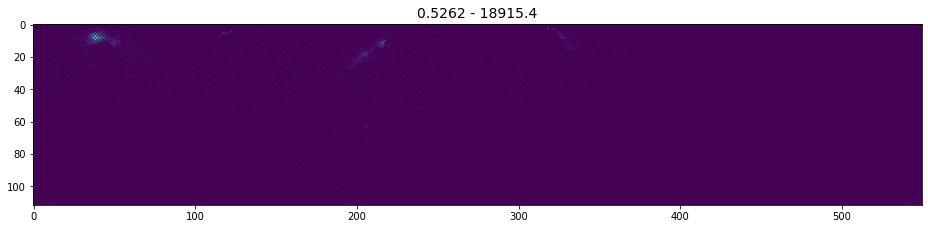

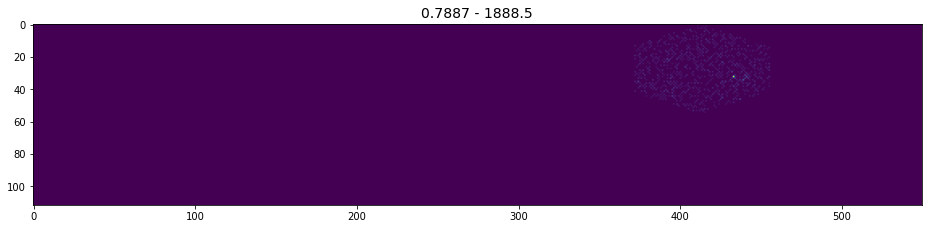

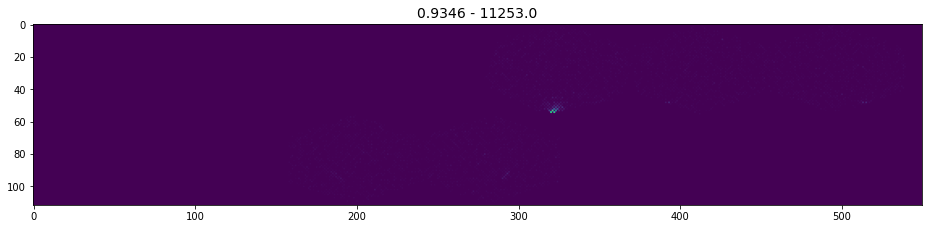

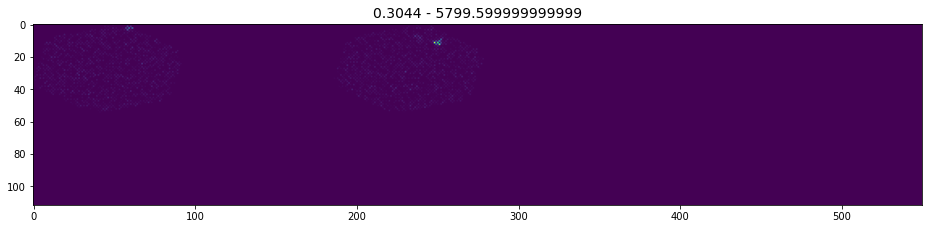

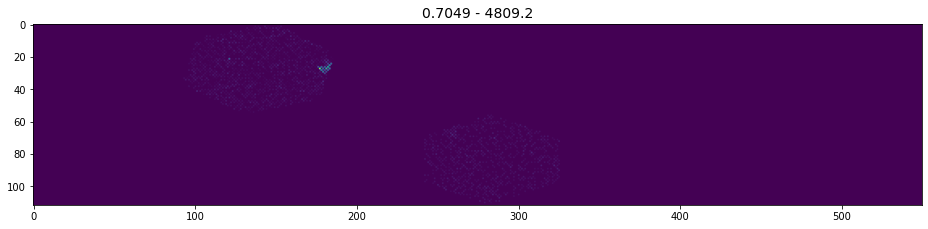

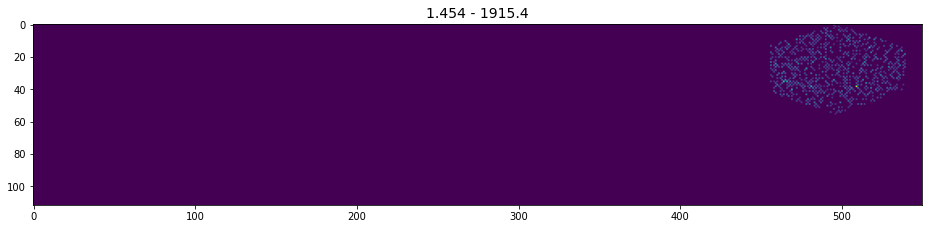

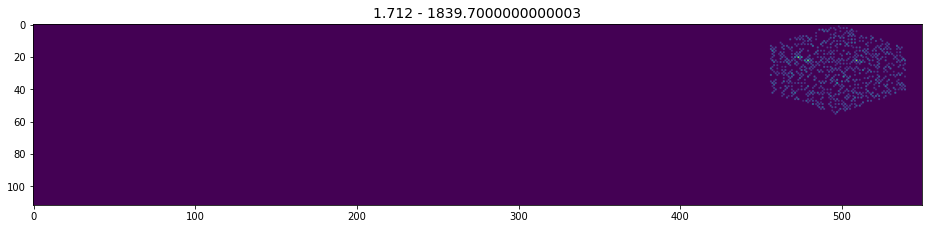

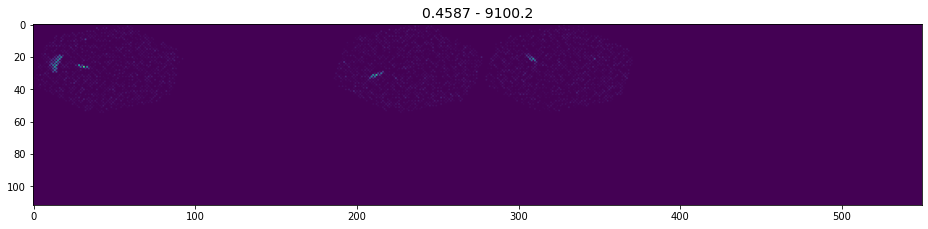

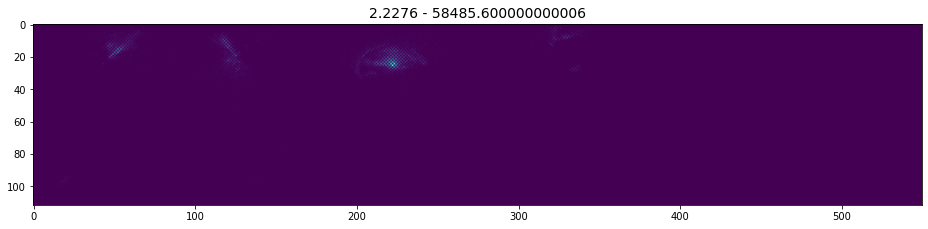

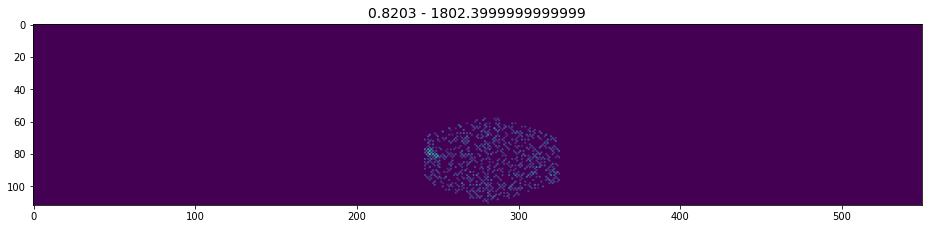

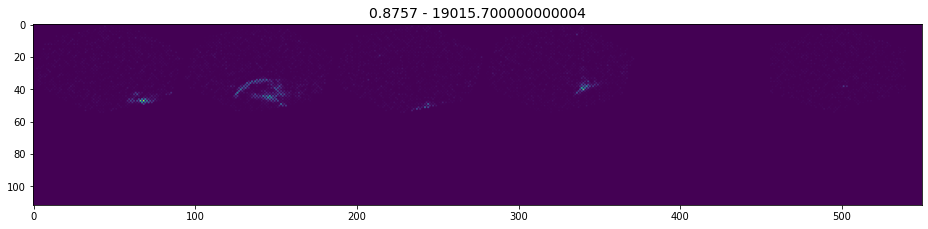

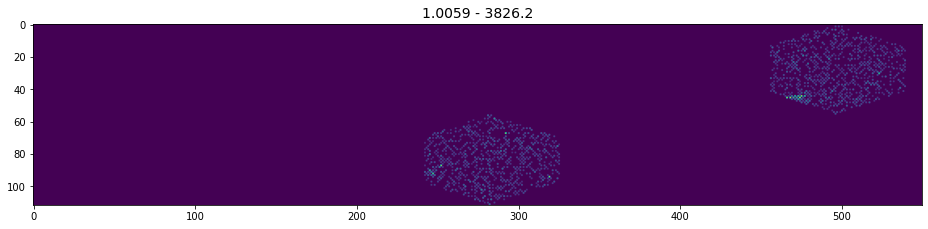

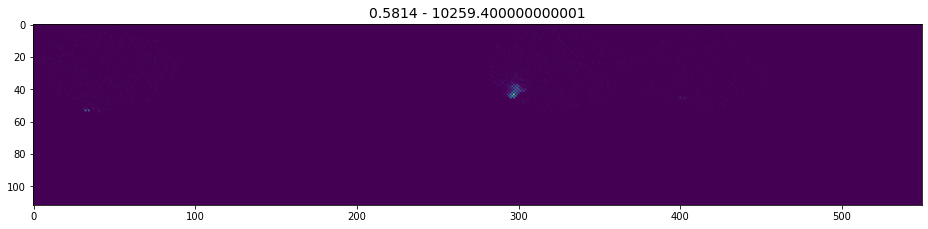

In [ ]:
#para ver como salen los inputs
elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
old_shape=x_train_clean[0,:,:,0].shape
new_shape=(int(old_shape[0]*2),int(old_shape[1]/2))
for i in range(1,14):
    plt.figure(figsize=(13,13))
    aux1,aux2=x_train_clean[i,:,:new_shape[1],0],x_train_clean[i,:,new_shape[1]:,0]
    aux_zeros=np.zeros(new_shape)
    aux_zeros[0:old_shape[0],:]=aux1
    aux_zeros[old_shape[0]:,:]=aux2
    del aux1,aux2
    plt.imshow(aux_zeros)
    plt.title(f"{y_train_clean[i]} - {np.sum(x_train_clean[i,:,:,0])}",fontsize=14)
    plt.tight_layout()

#Creamos modelo para adivinar las energias

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 56, 1100, 32)      320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 1100, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 550, 64)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 550, 64)       36928     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 550, 64)       36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 275, 64)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 275, 64)      

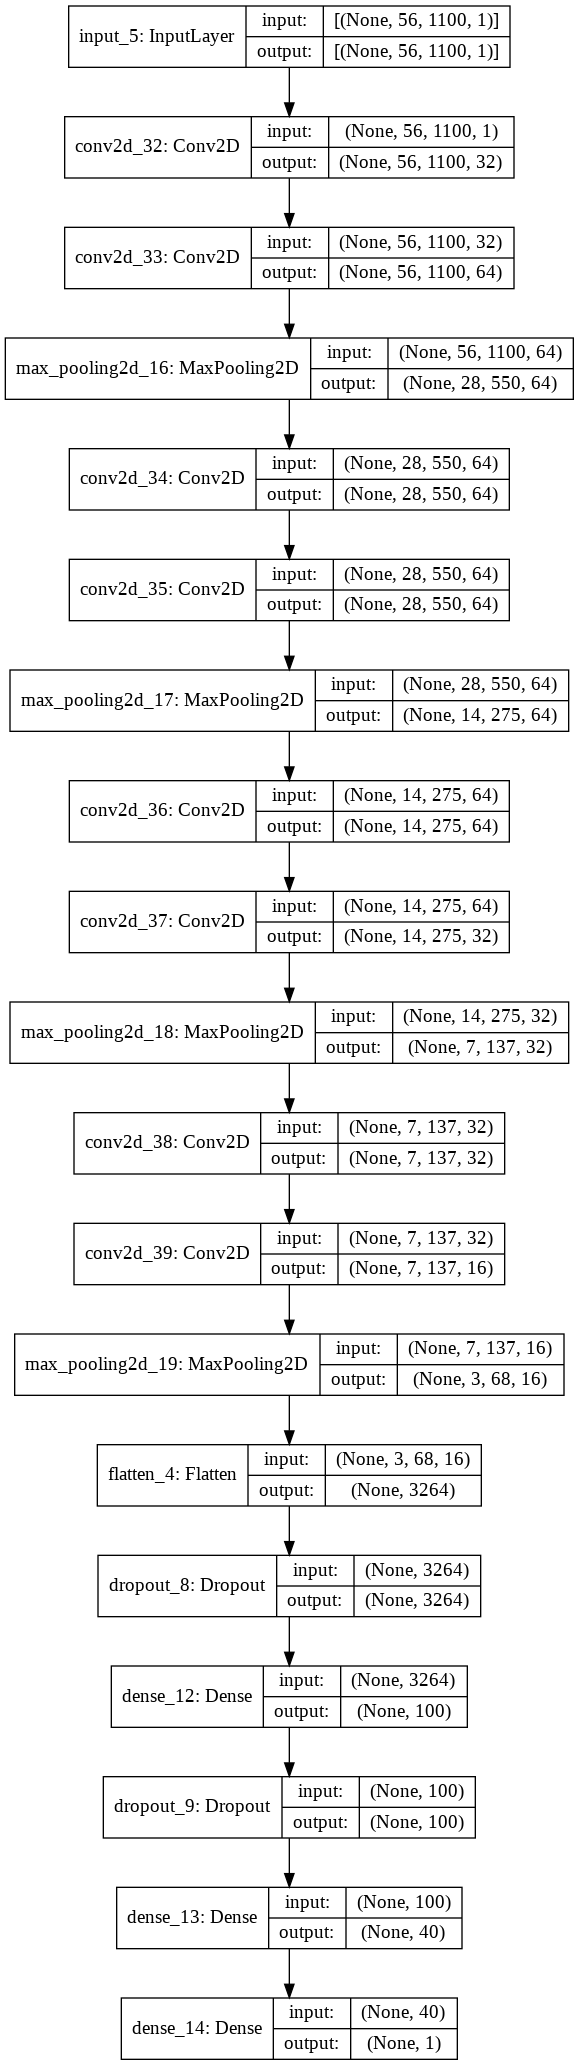

In [ ]:
#lo vamos a hacer con sequeantia fasil
tels=[4,5,6,11,29,30,31,32,33,34,101,102,103,104]
#tels=[4,5,6,11]

model=tf.keras.Sequential([tf.keras.Input(shape=(*shape_input(tels),1))])
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
#model.add(tf.keras.layers.MaxPool2D())
#model.add(tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
#model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(100,activation="relu",kernel_regularizer="l2"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(40,activation="relu"))
model.add(tf.keras.layers.Dense(1))
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss="mse")
stop=tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
hist=model.fit(x_train_clean,y_train_clean,epochs=30,batch_size=32,validation_data=(x_test_clean,y_test_clean),callbacks=[stop])

Epoch 1/30
367/367 [==============================] - 38s 102ms/step - loss: 0.6312 - val_loss: 0.5542
Epoch 2/30
367/367 [==============================] - 37s 100ms/step - loss: 0.5360 - val_loss: 0.5458
Epoch 3/30
367/367 [==============================] - 37s 100ms/step - loss: 0.5057 - val_loss: 0.5442
Epoch 4/30
367/367 [==============================] - 37s 100ms/step - loss: 0.5140 - val_loss: 0.5916
Epoch 5/30
367/367 [==============================] - 37s 100ms/step - loss: 0.5002 - val_loss: 0.5544
Epoch 6/30
367/367 [==============================] - 37s 100ms/step - loss: 0.4917 - val_loss: 0.5546
Epoch 7/30
367/367 [==============================] - 37s 100ms/step - loss: 0.4750 - val_loss: 0.5722
Epoch 8/30
367/367 [==============================] - 37s 100ms/step - loss: 0.4762 - val_loss: 0.5538


In [ ]:
y_predict=model.predict(x_test_clean)

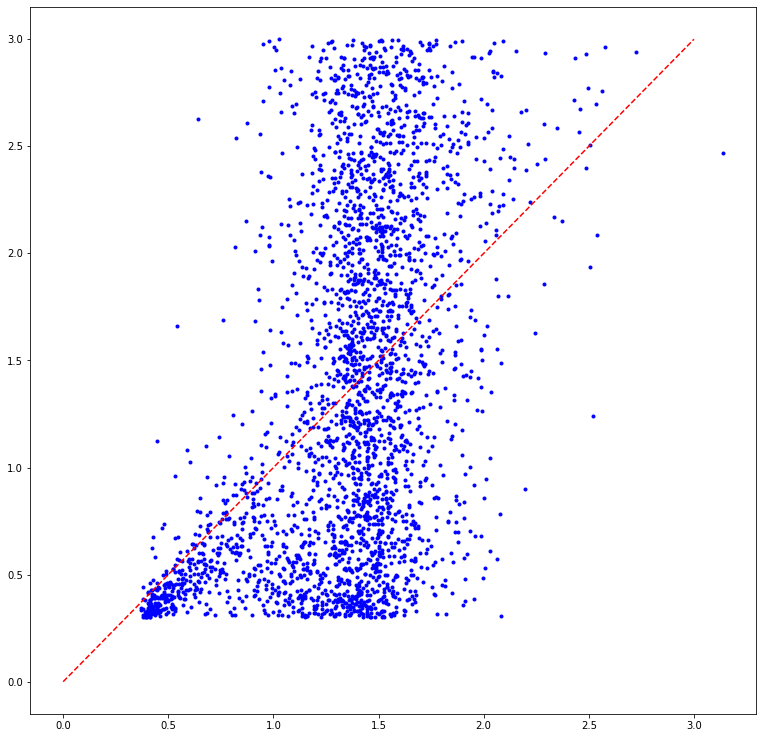

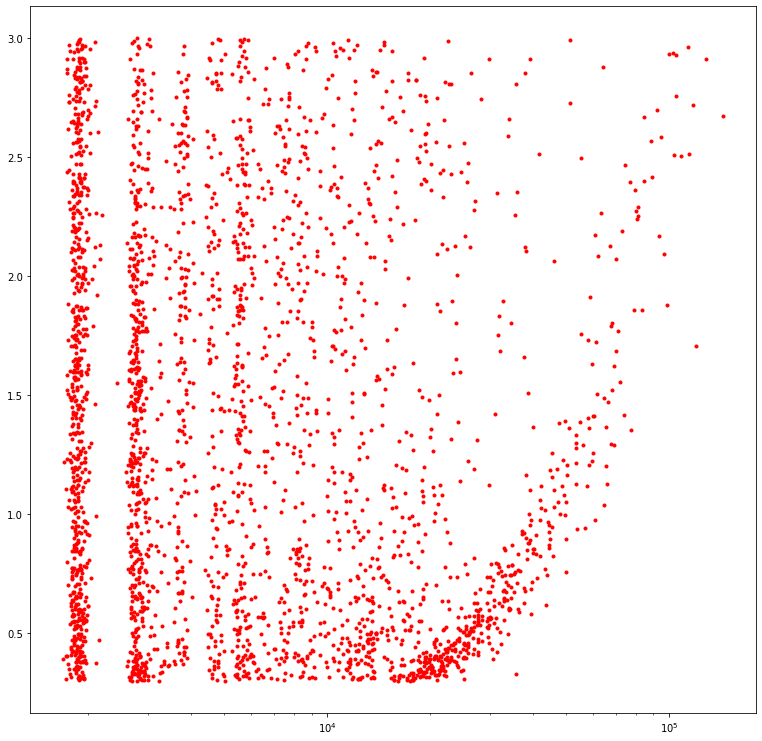

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(y_predict,y_test_clean,".b")
plt.plot([0,3],[0,3],"r--")
plt.figure(figsize=(13,13))
plt.plot([np.sum(i) for i in x_test_clean],y_test_clean,".r")
plt.xscale("log")
#

In [ ]:
#veamos si podemos mejorar la prediccion solo con un cambio lineal
#en cada ciclo calculamos la mse y lo vamos guardando
mse=[]
leng_predict=y_test_clean.shape[0]
for valores_pendiente in np.arange(0.6,1.45,0.05):
    mse_aux=[]
    for valores_cte in np.arange(1,1.1,0.05):
        y_predict_aux=y_predict*valores_pendiente+valores_cte
        valor_mse=np.sum((y_predict_aux-y_test_clean)**2)/leng_predict
        mse_aux.append(valor_mse)
    mse.append(np.asarray(mse_aux))
mse=np.asarray(mse)

ValueError: ignored

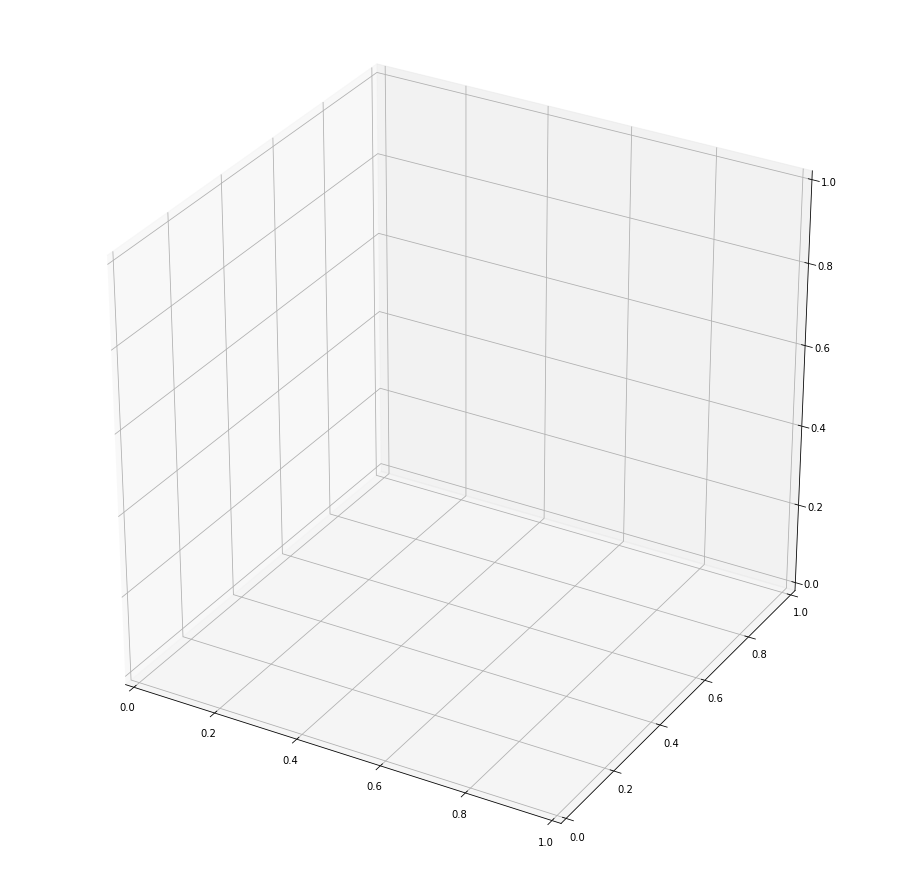

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
Y = np.arange(0.6,1.45,0.05)
X = np.arange(-1,1,0.05)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,mse)
ax.view_init(35,56)

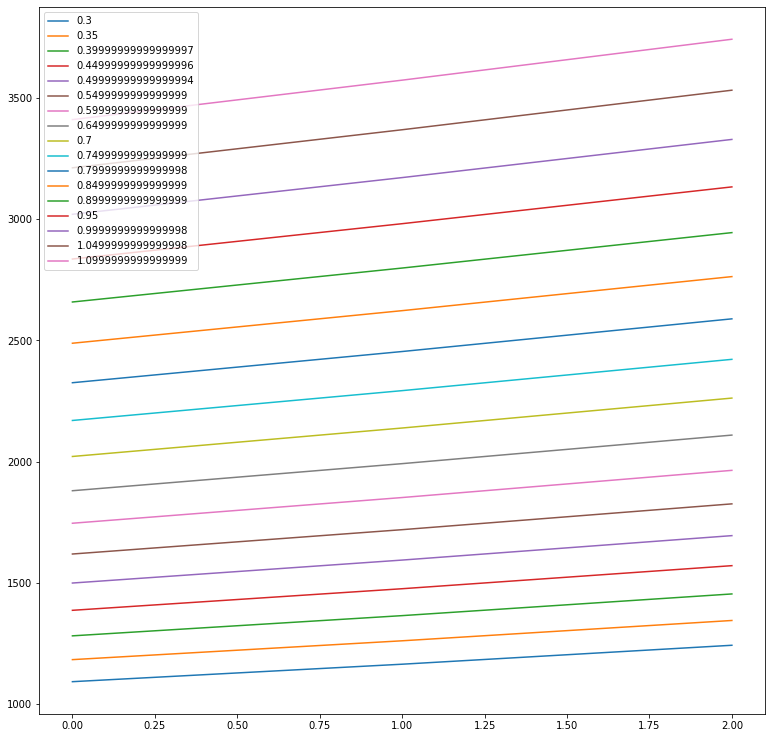

In [ ]:
plt.figure(figsize=(13,13))
Y = np.arange(0.3,1.45,0.05)
X = np.arange(-1,1,0.05)
for j,i in enumerate(mse):
    plt.plot(i,label=f"{Y[j]}")
plt.legend()


In [ ]:
mse

array([], shape=(17, 0), dtype=float64)

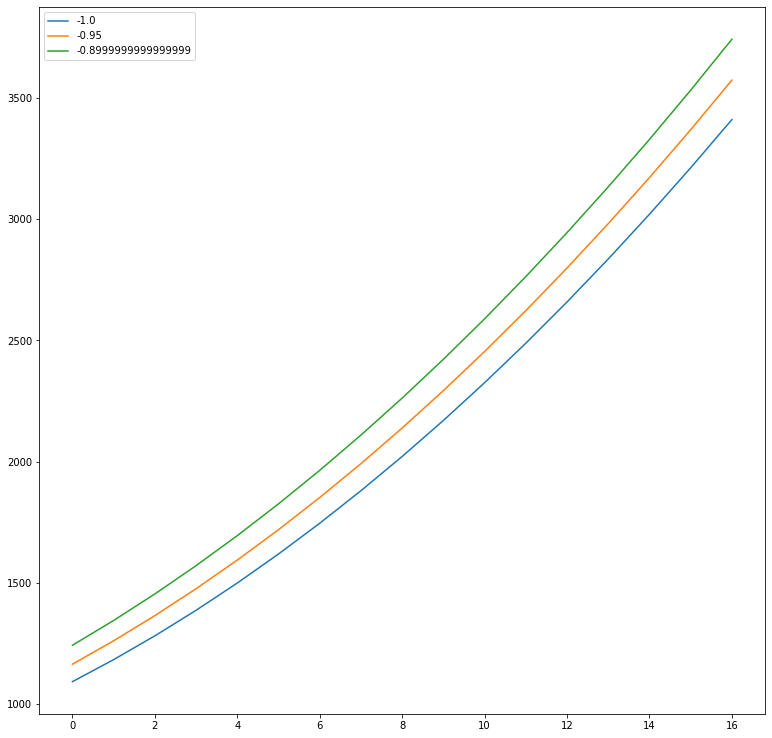

In [ ]:
plt.figure(figsize=(13,13))
Y = np.arange(0.6,1.45,0.05)
X = np.arange(-1,1,0.05)
for j,i in enumerate(mse.T):
    plt.plot(i,label=f"{X[j]}")
plt.legend()


In [ ]:
#que parametros dan el minimo
np.argmin(mse.flatten())

28

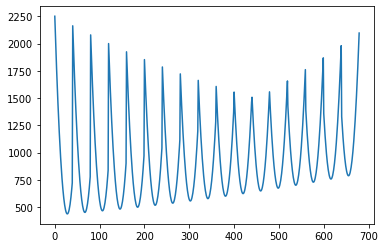

In [ ]:
plt.plot(mse.flatten())

In [ ]:
mse[28]

IndexError: ignored